## Updraft velocity P.D.F.s from MultiDop grids

In [10]:
import pyart
import gzip
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib import rcParams
import shutil, os
from datetime import timedelta, datetime
import numpy as np
import tempfile
import glob
import re
from copy import deepcopy
from IPython.display import Image, display
import math
from netCDF4 import Dataset
%matplotlib inline

Input time periods for analysis

In [11]:
# Input the range of dates and time wanted for the collection of images
start_year = 2006
start_day = 19
start_month = 1
start_hour = 4
start_minute = 00
start_second = 0

end_year = 2006
end_month = 1
end_day = 22
end_hour = 1
end_minute = 0
end_second = 0

data_path = '/home/rjackson/multidop_grids/'
data_path_sounding = '/home/rjackson/data/soundings/'

In [12]:
# get_radar_times
#     start_year = Start year of animation
#     start_month = Start month of animation
#     start_day = Start day of animation
#     start_hour = Start hour of animation
#     end_year = End year of animation
#     end_month = End month of animation
#     end_day = End day of animation
#     end_minute = End minute of animation
#     minute_interval = Interval in minutes between scans (default is 5)
# This procedure acquires an array of Radar classes between start_time and end_time  
def get_dda_times(start_year, start_month, start_day,
                  start_hour, start_minute, end_year,
                  end_month, end_day, end_hour, 
                  end_minute, minute_interval=5):

    start_time = datetime(start_year,
                      start_month,
                      start_day,
                      start_hour,
                      start_minute,
                      )
    end_time = datetime(end_year,
                      end_month,
                      end_day,
                      end_hour,
                      end_minute,
                      )

    deltatime = end_time - start_time


    if(deltatime.seconds > 0 or deltatime.minute > 0):
        no_days = deltatime.days + 1
    else:
        no_days = deltatime.days
    
    if(start_day != end_day):
        no_days = no_days + 1
        
    days = np.arange(0, no_days, 1)
    print('We are about to load grid files for ' + str(no_days) + ' days')
    

    # Find the list of files for each day
    cur_time = start_time
 
    file_list = []
    time_list = []
    for i in days:
        year_str = "%04d" % cur_time.year
        day_str = "%02d" % cur_time.day
        month_str = "%02d" % cur_time.month
        format_str = (data_path +
                      'cf_compliant_grid' +
                      year_str +
                      month_str +
                      day_str +
                      '*.nc')
    
    
        print('Looking for files with format ' + format_str)
          
        data_list = glob.glob(format_str)
        
        for j in range(0, len(data_list)):
            file_list.append(data_list[j])
        cur_time = cur_time + timedelta(days=1)
    
    
    # Parse all of the dates and time in the interval and add them to the time list
    past_time = []
    for file_name in file_list:
        date_str = file_name[-15:-3]
        year_str = date_str[0:4]
        month_str = date_str[4:6]
        day_str = date_str[6:8]
        hour_str = date_str[8:10]
        minute_str = date_str[10:12]
        second_str = '00'
             
        cur_time = datetime(int(year_str),
                            int(month_str),
                            int(day_str),
                            int(hour_str),
                            int(minute_str),
                            0)
        time_list.append(cur_time)
        
    
    # Sort time list and make sure time are at least xx min apart
    time_list.sort()
    time_list_sorted = deepcopy(time_list)
   
    time_list_final = []
    past_time = []
    
    
    for times in time_list_sorted: 
        
        cur_time = times  
        
        if(past_time == []):
            past_time = cur_time
            
        if(cur_time - past_time >= timedelta(minutes=minute_interval)
           and cur_time >= start_time and cur_time <= end_time):
            
            time_list_final.append(cur_time)
            past_time = cur_time
           
            
            
    
    return time_list_final

# Get a Radar object given a time period in the CPOL dataset
def get_grid_from_dda(time):
    year_str = "%04d" % time.year
    month_str = "%02d" % time.month
    day_str = "%02d" % time.day
    hour_str = "%02d" % time.hour
    minute_str = "%02d" % time.minute
    second_str = "%02d" % time.second
    file_name_str = (data_path +
                    'cf_compliant_grid' +
                     year_str +
                     month_str +
                     day_str +
                     hour_str +
                     minute_str + '.nc')
    
    radar = pyart.io.read_grid(file_name_str)
    return radar

In [13]:
# Plot the radars from given time.

times = get_dda_times(start_year, start_month, start_day,
                      start_hour, start_minute, end_year,
                      end_month, end_day, end_hour, 
                      end_minute, minute_interval=0)

We are about to load grid files for 4 days
Looking for files with format /home/rjackson/multidop_grids/cf_compliant_grid20060119*.nc
Looking for files with format /home/rjackson/multidop_grids/cf_compliant_grid20060120*.nc
Looking for files with format /home/rjackson/multidop_grids/cf_compliant_grid20060121*.nc
Looking for files with format /home/rjackson/multidop_grids/cf_compliant_grid20060122*.nc


Get pressure as a function of height from sounding

In [14]:
# get_sounding)times
#     start_year = Start year of animation
#     start_month = Start month of animation
#     start_day = Start day of animation
#     start_hour = Start hour of animation
#     end_year = End year of animation
#     end_month = End month of animation
#     end_day = End day of animation
#     end_minute = End minute of animation
#     minute_interval = Interval in minutes between scans (default is 5)
# This procedure acquires an array of sounding times between start_time and end_time. 
# Only 23 UTC is loaded following Pope et al. (2008)
def get_sounding_times(start_year, start_month, start_day,
                       start_hour, start_minute, end_year,
                       end_month, end_day, end_hour, 
                       end_minute, minute_interval=5):

    start_time = datetime(start_year,
                          start_month,
                          start_day,
                          start_hour,
                          start_minute,
                          )
    end_time = datetime(end_year,
                        end_month,
                        end_day,
                        end_hour,
                        end_minute,
                        )
    deltatime = end_time - start_time

    if(deltatime.seconds > 0 or deltatime.minutes > 0):
        no_days = deltatime.days + 1
    else:
        no_days = deltatime.days
    
    if(start_day != end_day):
        no_days = no_days + 1
        
    days = np.arange(0, no_days, 1)
    print('We are about to load sounding files for ' + str(no_days) + ' days')
    
    # Find the list of files for each day
    cur_time = start_time

    file_list = []
    time_list = []
    for i in days:
        year_str = "%04d" % cur_time.year
        day_str = "%02d" % cur_time.day
        month_str = "%02d" % cur_time.month
        format_str = (data_path_sounding +
                      'twpsondewnpnC3.b1.' +
                      year_str +
                      month_str +
                      day_str +
                      '*.23*'
                     '*custom.cdf')
    
          
        data_list = glob.glob(format_str)
        
        for j in range(0, len(data_list)):
            file_list.append(data_list[j])
        cur_time = cur_time + timedelta(days=1)
        
   
    # Parse all of the dates and time in the interval and add them to the time list
    past_time = []
    for file_name in file_list:
        date_str = file_name[-26:-11]  
        year_str = date_str[0:4]
        month_str = date_str[4:6]
        day_str = date_str[6:8]
        hour_str = date_str[9:11]
        minute_str = date_str[11:13]
        second_str = date_str[13:15]
                
        cur_time = datetime(int(year_str),
                            int(month_str),
                            int(day_str),
                            int(hour_str),
                            int(minute_str),
                            int(second_str))
        time_list.append(cur_time)
    
    # Sort time list and make sure time are at least xx min apart
    time_list.sort()
    time_list_sorted = deepcopy(time_list)
   
    time_list_final = []
    past_time = []
    
    for times in time_list_sorted: 
        
        cur_time = times  
        
        if(past_time == []):
            past_time = cur_time
            
        if(cur_time - past_time >= timedelta(minutes=minute_interval)
           and cur_time >= start_time and cur_time <= end_time):
            
            time_list_final.append(cur_time)
            past_time = cur_time
               
    return time_list_final

# Get a Radar object given a time period in the CPOL dataset
def get_sounding(time):
    year_str = "%04d" % time.year
    month_str = "%02d" % time.month
    day_str = "%02d" % time.day
    hour_str = "%02d" % time.hour
    minute_str = "%02d" % time.minute
    second_str = "%02d" % time.second
    file_name_str = (data_path_sounding +
                     'twpsondewnpnC3.b1.' +
                     year_str +
                     month_str +
                     day_str +
                     '.' +
                     hour_str +
                     minute_str +
                     second_str +
                     '.custom.cdf')
    sounding = Dataset(file_name_str, mode='r')
    return sounding

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

In [15]:
sounding_times = get_sounding_times(start_year,
                                    start_month,
                                    start_day,
                                    start_hour,
                                    start_minute, 
                                    end_year,
                                    end_month,
                                    end_day,
                                    end_hour,
                                    end_minute)

Sounding_netcdf = get_sounding(sounding_times[0])

p = Sounding_netcdf.variables['pres'][:]           
z = Sounding_netcdf.variables['alt'][:]

z_levels = np.arange(0.5,16.5,0.5)*1000

p_levels = np.zeros(z_levels.shape)
count = 0
for z_value in z_levels:
    index = find_nearest(z, z_value)
    p_levels[count] = p[index]
    count = count + 1

Sounding_netcdf.close()
print(p_levels)
print(z_levels)

We are about to load sounding files for 4 days
[ 952.79998779  900.40002441  849.5         800.79998779  755.59997559
  711.20001221  669.70001221  630.40002441  592.70001221  557.59997559
  523.20001221  491.3999939   460.70001221  432.29998779  405.20001221
  379.29998779  354.70001221  331.20001221  309.6000061   288.70001221
  268.79998779  250.19999695  232.30000305  215.80000305  199.69999695
  184.8999939   170.6000061   157.5         144.80000305  133.          122.
  111.80000305]
[   500.   1000.   1500.   2000.   2500.   3000.   3500.   4000.   4500.
   5000.   5500.   6000.   6500.   7000.   7500.   8000.   8500.   9000.
   9500.  10000.  10500.  11000.  11500.  12000.  12500.  13000.  13500.
  14000.  14500.  15000.  15500.  16000.]


Code to get beam crossing angle (adopted from multidop (Potvin/Lang))

In [16]:
def get_bca(grid):
    berr_origin = [-12960.1,-23091.1]
    x,y = np.meshgrid(grid.x['data'], grid.y['data'])
    a = np.sqrt(np.multiply(x,x)+np.multiply(y,y))
    b = np.sqrt(pow(x-berr_origin[0],2)+pow(y-berr_origin[1],2))
    c = np.sqrt(berr_origin[0]*berr_origin[0]+berr_origin[1]*berr_origin[1])
    theta_1 = np.arccos(x/a)
    theta_2 = np.arccos((x-berr_origin[1])/b)
    return np.arccos((a*a+b*b-c*c)/(2*a*b))

Code to retrieve all vertical velocities within x degree beam crossing angle

In [17]:
count = 0

time = times[122]
dc = np.ma.zeros((len(times), 81, 111))
ws = np.ma.zeros((len(times), 32, 81, 111))
rfs = np.ma.zeros((len(times), 32, 81, 111))
print(ws.shape)
for time in times:
    pyart_grid = get_grid_from_dda(time)
    bca = get_bca(pyart_grid)
    w = pyart_grid.fields['upward_air_velocity']['data']
    updraft_depth = np.zeros(w[0].shape)
    z = pyart_grid.fields['reflectivity']['data']
    for levels in range(0,19):
        w[levels] = np.ma.masked_where(np.logical_and(np.logical_or(bca < math.pi/6,
                                                                    bca > 5*math.pi/6), 
                                                       z[levels] > 1), w[levels])
        
        is_in_updraft = w[levels] > 1
        is_in_updraft_next = w[levels+1] > 1
        both_in_updraft = np.logical_or(np.logical_and(is_in_updraft,is_in_updraft_next),
                                        updraft_depth > 10)
        
        add_one = np.where(both_in_updraft)
        set_to_zero = np.where(~both_in_updraft)
        if(len(add_one[0]) > 0):
            updraft_depth[add_one[0], add_one[1]] = updraft_depth[add_one[0], add_one[1]] + 1 
            updraft_depth[set_to_zero[0], set_to_zero[1]] = 0       
    
    dc[count] = updraft_depth
    ws[count] = w
    rfs[count] = z
    count = count + 1

(398, 32, 81, 111)


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in arccos
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in true_divide
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in less
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in greater


## Display vertical velocity PDF

/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


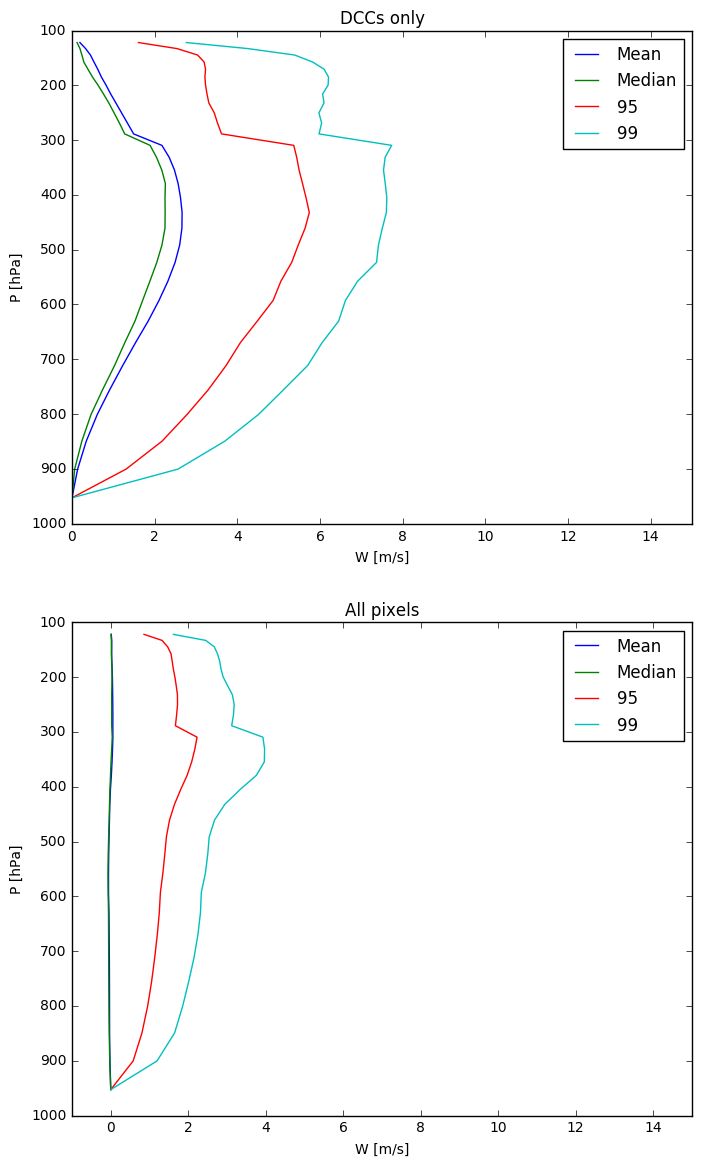

In [18]:
mean_w = np.ma.zeros(32)
median_w = np.ma.zeros(32)
ninety_five_w = np.ma.zeros(32)
ninety_nine_w = np.ma.zeros(32)
dims = ws.shape

for levels in range(0,32):
    w_level = ws[:,levels,:,:]
    r_level = rfs[:,levels,:,:]
    for i in range(0, dims[0]):
        w_level[i,:,:] = np.ma.masked_where(np.logical_or(dc[i,:,:] < 10, r_level[i,:,:] < 1)
                                            ,w_level[i,:,:])
    
    ws_in_core = w_level[~w_level.mask]
    mean_w[levels] = np.ma.mean(ws_in_core)
    median_w[levels] = np.ma.median(ws_in_core)
    
    if(len(ws_in_core) > 0):
        ninety_five_w[levels] = np.percentile(ws_in_core, 95)
        ninety_nine_w[levels] = np.percentile(ws_in_core, 99)
    else:
        ninety_five_w[levels] = float('nan')
        ninety_nine_w[levels] = float('nan')
     
plt.figure(figsize=(8,14))
plt.subplot(211)
h1 = plt.plot(mean_w, p_levels, label="Median")
h2 = plt.plot(median_w, p_levels, label="Mean")
h3 = plt.plot(ninety_five_w, p_levels, label="95")
h4 = plt.plot(ninety_nine_w, p_levels, label="99")
plt.xlabel('W [m/s]')
plt.ylabel('P [hPa]')
plt.legend(['Mean', 'Median', '95', '99'], loc='best')
plt.xlim((0,15))
plt.gca().invert_yaxis()
plt.title('DCCs only')

for levels in range(0,32):
    w_level = ws[:,levels,:,:]
    r_level = rfs[:,levels,:,:]
    #for i in range(0, dims[0]):
    #    w_level[i,:,:] = np.ma.masked_where(np.logical_or(dc[i,:,:] < 10, r_level[i,:,:] < 10)
    #                                        ,w_level[i,:,:])
    
    ws_in_core = w_level[~w_level.mask]
    mean_w[levels] = np.ma.mean(ws_in_core)
    median_w[levels] = np.ma.median(ws_in_core)
    
    if(len(ws_in_core) > 0):
        ninety_five_w[levels] = np.percentile(ws_in_core, 95)
        ninety_nine_w[levels] = np.percentile(ws_in_core, 99)
    else:
        ninety_five_w[levels] = float('nan')
        ninety_nine_w[levels] = float('nan')
        
plt.subplot(212)
h1 = plt.plot(mean_w, p_levels, label="Median")
h2 = plt.plot(median_w, p_levels, label="Mean")
h3 = plt.plot(ninety_five_w, p_levels, label="95")
h4 = plt.plot(ninety_nine_w, p_levels, label="99")
plt.xlabel('W [m/s]')
plt.ylabel('P [hPa]')
plt.legend(['Mean', 'Median', '95', '99'], loc='best')
plt.xlim((-1,15))
plt.gca().invert_yaxis()
plt.title('All pixels')